# Démonstration : fit d'un spectre de rubis avec Python

De nombreuses opérations peuvent être réalisées grâce aux fonctions natives de Python. Malgré cela on commence souvent par importer quelques *modules* qui vont apporter des fonctionnalités supplémentaires.
Ici, nous allons importer des grands classiques:

* `numpy` : algèbre linéaire et mathématiques
* `matplotlib` : tracé graphique
* `scipy` : calcul scientifique, ici la fonction `curve_fit` qui sert aux regression non linéaires


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Pour tracer des figures de bonne qualité avec matplotlib (format vectoriel) directement dans le notebook :
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

On a ici procédé à 2 types d'import:

* le format `import module as alias` pour importer un module et toutes ses méthodes (fonctionnalités), que l'on pourra appeler en utilisant `alias.methode`.
* le format `from module import methode`qui permet de n'importer qu'une seule méthode (fonctionnalité) du module `module`, que l'on pourra appeler directement.

Notons que certains modules ont un format de "packages", c'est à dire qu'ils contiennent des sous-modules : c'est le cas par exemple dans l'instruction `from scipy.optimize import curve_fit` où seule la fonction `curve_fit` issue du sous-module `optimize` de `scipy` est chargée.

## Chargement du fichier de données

On commence par charger le fichier de données ASCII, obtenu lors de la mesure spectroscopique. Le fichier contient deux colonnes : les longueurs d'onde en nm, et les intensités (en unité arbitaire). On utilise la fonction [`loadtxt`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) fournie par le module `numpy` pour charger les données :

In [26]:
# Read data from text file:
# les colonnes sont séparées par le caractère tab, codé par \t
data = np.loadtxt('Exemple_Rubis.asc', delimiter='\t')

# La première colonne correspond aux longueurs d'ondes :
x_data = data[:, 0]          # ici, le ':' indique que l'on conserve toutes les lignes
# La seconde aux intensités :
y_data = data[:, 1]

# affichons un aperçu des tableaux obtenus:
print('x:', x_data)
print('y:', y_data)

x: [687.98301872 687.99579861 688.00905234 ... 701.10187015 701.11415896
 701.12693978]
y: [541. 514. 495. ... 626. 655. 635.]


## Tracé des données

Nous utilisons la bibliothèque `matplotlib` afin de visualiser les données. Nous ajoutons des étiquettes d'axes et une légende.

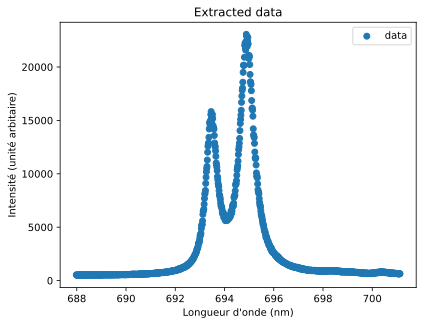

In [27]:
# on crée une figure :
plt.figure(1)

# on trace les données sous la forme d'un nuage de points, avec plt.scatter:
plt.scatter(x_data, y_data, label='data')

# On ajoute des étiquettes d'axe
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel('Intensité (unité arbitaire)')

# On ajoute la légende, qui va indiqué le nom donné en "label" ci-dessus
plt.legend() 

# et un titre:
plt.title('Extracted data')

plt.show()

## Ajustement d'une fonction avec la fonction `curve_fit` de `scipy`

Nous allons réaliser un ajustement en utilisant deux fonctions *lorentziennes*. Il nous faut pour cela définir une fonction décrivant le profil lorentzien tel que : 
$$
\Large I(\nu) = \frac{A}{1 + \left(\frac{\nu-\nu_0}{\Gamma/2}\right)^2}
$$

où $A$ est hauteur (maximum) de la fonction, $\nu_0$ la position de ce maximum, et $\Gamma$ la largeur à mi-hauteur.

In [28]:
def lorentzian(x, A, x0, gamma):
    return A/(1 + ( (x-x0)/(gamma/2) )**2)

A partir de cette fonction, on peut définir un modèle pour représenter le spectre de luminescence du rubis comme la somme de deux fonction lorentzienne et d'une constante $c$ représentant le fond. 

In [29]:
def ruby_model(x, A1, x1, gamma1, A2, x2, gamma2, c):
    return lorentzian(x, A1, x1, gamma1) + lorentzian(x, A2, x2, gamma2) + c

On définit les paramètres initiaux pour le fit, puis on appelle la fonction [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) pour réaliser l'ajustement :

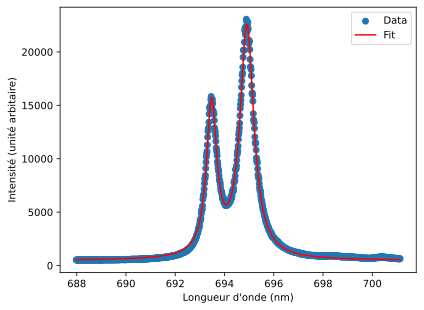

Optimized Parameters:
A1:     14100.697570947465
x1:     693.4760009771001
gamma1: 0.506415187477642
A2:     21688.05798297606
x2:     694.9096268317035
gamma2: 0.6788096374811154
c:      474.14708847288955


In [30]:
# les paramètres initiaux sont renseignés dans l'ordre défini ci-dessus dans la fonction ruby_model, tel que
# [A1, x1, gamma1, A2, x2, gamma2]
initial_guesses = [15000, 693.5, 0.5, 20000, 695, 0.5, 0]

# On réalise le fit :
# les paramètres optimisés sont stockés dans popt
# la matrice de covariance est stockée dans pcov:

popt, pcov = curve_fit(ruby_model, x_data, y_data, p0=initial_guesses)

# On trace les données brutes et le fit obtenu
plt.figure()
plt.scatter(x_data, y_data, label='Data')

plt.plot(x_data, ruby_model(x_data, *popt), color='red', label='Fit')
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel('Intensité (unité arbitaire)')
plt.legend()
plt.show()

# On affiche les paramètres obtenus
print("Optimized Parameters:")
print("A1:    ", popt[0])
print("x1:    ", popt[1])
print("gamma1:", popt[2])
print("A2:    ", popt[3])
print("x2:    ", popt[4])
print("gamma2:", popt[5])
print("c:     ", popt[6])


# Ajustement avec des profils de Voigt

Il est habituel d'utiliser des profils de Voigt pour le fit des raies de luminescence du rubis, afin de mieux décrire les spectres expérimentaux et de déterminer la position spectrale du maximum de la manière la plus fiable possible. Le profil de Voigt est issu de la convolution d'un profil Lorentzien décrivant la largeur intrinsèque de la raie de luminescence du rubis, et d'un profil Gaussien décrivant un élargissement expérimental lié à la résolution spectrale de l'instrument. 

Nous allons faire appel à la bibliothèque scipy qui fournit directement une fonction [`voigt_profile`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.voigt_profile.html). En revanche celle-ci est centrée en $x=0$ et normalisée. Nous allons donc encapsuler cette fonction dans une autre fonction `voigt` dont les paramètres sont la position du pic $x0$, sa __hauteur__ au maximum $A$, l'écart-type du profil Gaussien $\sigma$, et la largeur à mi-hauteur du profil Lorentzien $\Gamma$.

In [31]:
# on importe directement la fonction voigt_profile:
from scipy.special import voigt_profile

# on définit la fonction de Voigt telle que son maximum vaut A en x0
def voigt(x, A, x0, sigma, gamma):
    v = voigt_profile(x-x0, sigma, gamma)
    f = A * v / np.max(v)
    return f

# on définit une fonction pour décrire le spectre du rubis avec deux fonctions de voigts et un fond constant:
def ruby_model_voigt(x, A1, x1, sigma1, gamma1, A2, x2, sigma2, gamma2, c):
    return voigt(x, A1, x1, sigma1, gamma1) + voigt(x, A2, x2, sigma2, gamma2) + c

Comme précédemment on définit les paramètres initiaux pour le fit, puis on appelle la fonction [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) pour réaliser l'ajustement :

/tmp/ipykernel_7499/3851673753.py:7: RuntimeWarning: invalid value encountered in divide
  f = A * v / np.max(v)


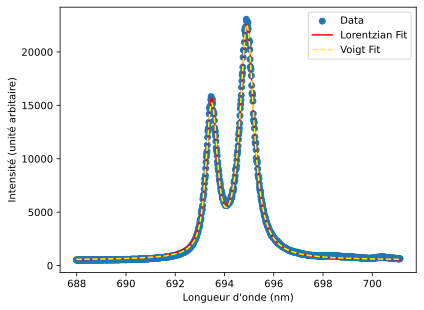

Optimized Parameters:
A1:     13532.489848416164
x1:     693.4760003298168
sigma1: 0.12560040833103836
gamma1: 0.18938220333894024
A2:     21725.223524863606
x2:     694.9075661925772
sigma2: 6.828797485480577e-05
gamma2: 0.3435269789074577
c:      507.0980284566633


In [32]:
# les paramètres initiaux sont renseignés dans l'ordre défini ci-dessus dans la fonction ruby_model_voigt:
initial_guesses2 = [15000, 693.5, 0.1, 0.1, 20000, 695, 0.1, 0.1, 0]

# On réalise le fit et on stocke les résultats dans popt2, pcov2 :
popt2, pcov2 = curve_fit(ruby_model_voigt, x_data, y_data, p0=initial_guesses2)

# On trace les données brutes et le fit obtenu
plt.figure()
plt.scatter(x_data, y_data, label='Data')

# on trace aussi le précédent fit avec les lorentziennes pour comparaison:
plt.plot(x_data, ruby_model(x_data, *popt), color='r',  label='Lorentzian Fit')

plt.plot(x_data, ruby_model_voigt(x_data, *popt2), color='yellow', linestyle='--',label='Voigt Fit')
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel('Intensité (unité arbitaire)')
plt.legend()
plt.show()

# On affiche les paramètres obtenus
print("Optimized Parameters:")
print("A1:    ", popt2[0])
print("x1:    ", popt2[1])
print("sigma1:", popt2[2])
print("gamma1:", popt2[3])
print("A2:    ", popt2[4])
print("x2:    ", popt2[5])
print("sigma2:", popt2[6])
print("gamma2:", popt2[7])
print("c:     ", popt2[8])

Les fits obtenus sont très similaires. Comparons les positions spectrales du pic R1 du rubis obtenues avec le fit lorentzien ou Voigt.  Pour calculer les erreurs (écarts-type) sur les résultats du fit, on prends la racine des élements diagonaux de la matrice de covariance. Celle-ci à été définie lors de l'appel à la fonction `curve_fit`, et stockée dans `pcov` et `pcov2` pour les fits Lorentziens et Voigt respectivement (voir plus haut).

In [33]:
print('R1-line using Lorentzians fit    :', popt[4],  '+/-', np.sqrt( np.diag(pcov))[4], ' nm')
print('R1-line using Voigt fit          :', popt2[5], '+/-', np.sqrt( np.diag(pcov2))[5], ' nm')

R1-line using Lorentzians fit    : 694.9096268317035 +/- 0.0006565569525496895  nm
R1-line using Voigt fit          : 694.9075661925772 +/- 0.0005710390171948986  nm


## Ajustement avec la bibliothèque `lmfit`

La bibliothèque [`lmfit`](https://lmfit.github.io/lmfit-py/) permet de réaliser le même type d'ajustement. L'interface de fit est différente car `lmfit` possède déjà un grand nombre de [modèles pré-définis](https://lmfit.github.io/lmfit-py/builtin_models.html), tels que les Lorentziennes, Gaussiennes, Voigt, etc...  `lmfit` dispose également d'une série de fonctionnalités plus avancées et bien utiles, comme par exemple l'affichage d'un rapport détaillé du fit et des statistiques associées qui sont calculées automatiquement (voir ci-dessous). 

Nous allons ici créer un modèle `lmfit`, tel que la somme de deux Voigts et d'une constante :

[[Model]]
    ((Model(voigt, prefix='V1_') + Model(voigt, prefix='V2_')) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 104
    # data points      = 1024
    # variables        = 9
    chi-square         = 25863161.9
    reduced chi-square = 25480.9477
    Akaike info crit   = 10398.1430
    Bayesian info crit = 10442.5262
    R-squared          = 0.99884062
[[Variables]]
    V1_amplitude:  10391.1516 +/- 58.9761202 (0.57%) (init = 15000)
    V1_center:     693.476001 +/- 7.7198e-04 (0.00%) (init = 693.5)
    V1_sigma:      0.12561227 +/- 0.00345438 (2.75%) (init = 0.1)
    V2_amplitude:  23448.7263 +/- 69.0974215 (0.29%) (init = 20000)
    V2_center:     694.907555 +/- 5.7321e-04 (0.00%) (init = 695)
    V2_sigma:      3.1758e-06 +/- 65.2280218 (2053916544.86%) (init = 0.1)
    c:             507.110237 +/- 6.70117735 (1.32%) (init = 0)
    V1_gamma:      0.18936751 +/- 0.00359894 (1.90%) (init = 0.1)
    V1_fwhm:       0.54679996 +/- 0

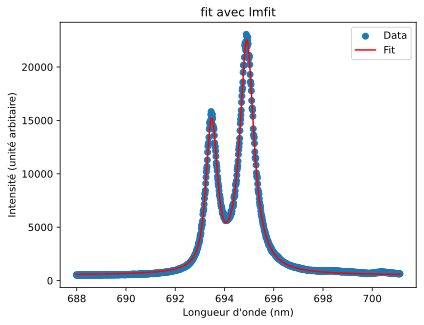

In [34]:
# On importe les fonctions nécessaires du module lmfit.models : 
from lmfit.models import VoigtModel, LorentzianModel, ConstantModel

# On crée un modèle: la somme de deux VoigtModel et d'un ConstantModel.
# on peut définir un prefixe pour chaque sous-fonction afin de les identifier ensuite par ce nom:
model = VoigtModel(prefix='V1_') + VoigtModel(prefix='V2_') + ConstantModel()

# On crée un jeu de paramètres initiaux et on renseigne des valeurs initiales :
# /!\ les nom de paramètres ajouté derrière les préfixes sont fixés, il faut regarder dans la doc de lmfit.
params = model.make_params(V1_amplitude = 15000, 
                           V1_center = 693.5, 
                           V1_sigma = 0.1,
                           V1_gamma = 0.1,
                           V2_amplitude = 20000, 
                           V2_center = 695,
                           V2_sigma = 0.1,
                           V2_gamma = 0.1,
                           c = 0)  # Adjust initial guesses as per your data

# Par défaut gamma est fixé égal à sigma dans VoigtModel
# on force donc lmfit a faire varier gamma indépendamment. 

params['V1_gamma'].set(vary=True, expr='')
params['V2_gamma'].set(vary=True, expr='')


# on effectue le fit. Les résultats seront stockés dans result:
result = model.fit(y_data, params, x=x_data)

# On peut afficher un rapport détaillé du fit:
print(result.fit_report())

# On trace les données brutes et le fit obtenu
plt.figure()
plt.scatter(x_data, y_data, label='Data')

# il suffit ici d'appeler result.best_fit pour l'axe y :
plt.plot(x_data, result.best_fit, color='red', label='Fit')

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel('Intensité (unité arbitaire)')
plt.legend()
plt.title('fit avec lmfit')
plt.show()

On peut afficher le résultat sous la forme d'un tableau contenant les différents paramètres obtenus, leurs erreurs statistiques, leurs valeurs initiales, etc :

In [35]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
V1_amplitude,10391.1516,58.9761202,(0.57%),15000.0,-inf,inf,True,
V1_center,693.476001,7.7198e-04,(0.00%),693.5,-inf,inf,True,
V1_sigma,0.12561227,0.00345438,(2.75%),0.1,0.00000000,inf,True,
V2_amplitude,23448.7263,69.0974215,(0.29%),20000.0,-inf,inf,True,
V2_center,694.907555,5.7321e-04,(0.00%),695.0,-inf,inf,True,
V2_sigma,3.1758e-06,65.2280218,(2053916544.86%),0.1,0.00000000,inf,True,
c,507.110237,6.70117735,(1.32%),0.0,-inf,inf,True,
V1_gamma,0.18936751,0.00359894,(1.90%),0.1,-inf,inf,True,
V1_fwhm,0.54679996,0.00266931,(0.49%),0.3601290638188136,-inf,inf,False,1.0692*V1_gamma+sqrt(0.8664*V1_gamma**2+5.545083*V1_sigma**2)
V1_height,13537.5041,43.3427460,(0.32%),31306.392078055156,-inf,inf,False,"(V1_amplitude/(max(1e-15, V1_sigma*sqrt(2*pi))))*real(wofz((1j*V1_gamma)/(max(1e-15, V1_sigma*sqrt(2)))))"


La position de la raie de luminescence R1 est :

In [36]:
result.params['V2_center']

<Parameter 'V2_center', value=694.9075547385249 +/- 0.000573, bounds=[-inf:inf]>